In [31]:
import pandas as pd

# Path to your dataset (use WSL path, not C:\...)
csv_path = "/mnt/c/School files/Year 2 Modules/Learning with side projects/RNN projects/archive/ETH-USD_data.csv"

# Load into pandas DataFrame
df = pd.read_csv(csv_path)

# Peek at the first few rows
print(df.shape)
print(df.columns)
df.head()


(1568, 6)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


,Date,Open,High,Low,Close,Volume
0,2/23/2022,2639.447021,2741.368408,2587.412842,2590.359619,13382637240
1,2/22/2022,2572.898682,2648.916748,2510.678711,2639.299316,16360200507
2,2/21/2022,2627.665527,2752.458496,2568.254395,2573.816162,18646392740
3,2/20/2022,2763.756592,2763.756592,2585.946289,2628.648438,11641437834
4,2/19/2022,2784.872803,2826.347900,2707.378418,2763.701172,9774183169


In [38]:
# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by time (just in case)
df = df.sort_values('Date')

# For now, use only the 'Close' column
data = df[['Close']].values

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale values between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print("Scaled data shape:", scaled_data.shape)


Scaled data shape: (1568, 1)


In [49]:
# Hyperparameters
lookback = 60   # use past 60 days
# Example (lookback = 60):
# Sample 1 → days 1–60 → predict day 61
# Sample 2 → days 2–61 → predict day 62
# Sample 3 → days 3–62 → predict day 63

X, y = [], []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])  # 60 timesteps
    y.append(scaled_data[i, 0])            # next timestep

# it's slicing up 60 day chunks for the LSTM model

X, y = np.array(X), np.array(y)

# Reshape for LSTM: (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (1508, 60, 1) y shape: (1508,)


In [50]:
# 70% train, 15% val, 15% test
train_size = int(len(X) * 0.7)
val_size   = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val,   y_val   = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test,  y_test  = X[train_size+val_size:], y[train_size+val_size:]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (1055, 60, 1) Val: (226, 60, 1) Test: (227, 60, 1)


In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    layers.Dense(1)  # regression: predict next price
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/home/samuel/tf_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0010 - mae: 0.0214 - val_loss: 0.0043 - val_mae: 0.0494
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.7345e-05 - mae: 0.0054 - val_loss: 0.0037 - val_mae: 0.0452
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.1060e-04 - mae: 0.0059 - val_loss: 0.0035 - val_mae: 0.0442
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0682e-04 - mae: 0.0062 - val_loss: 0.0032 - val_mae: 0.0424
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4455e-05 - mae: 0.0050 - val_loss: 0.0023 - val_mae: 0.0333
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.3630e-05 - mae: 0.0049 - val_loss: 0.0039 - val_mae: 0.0495
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.4570e-05 - mae: 0.0057 - val_loss: 0.0024 - val_mae: 0.0357
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1323e-05 - mae: 0.0047 - val_loss: 0.0019 - val_mae: 0.0302
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mae: 0.0371 
Test MSE: 0.002026477362960577 Test MAE: 0.03753947094082832
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


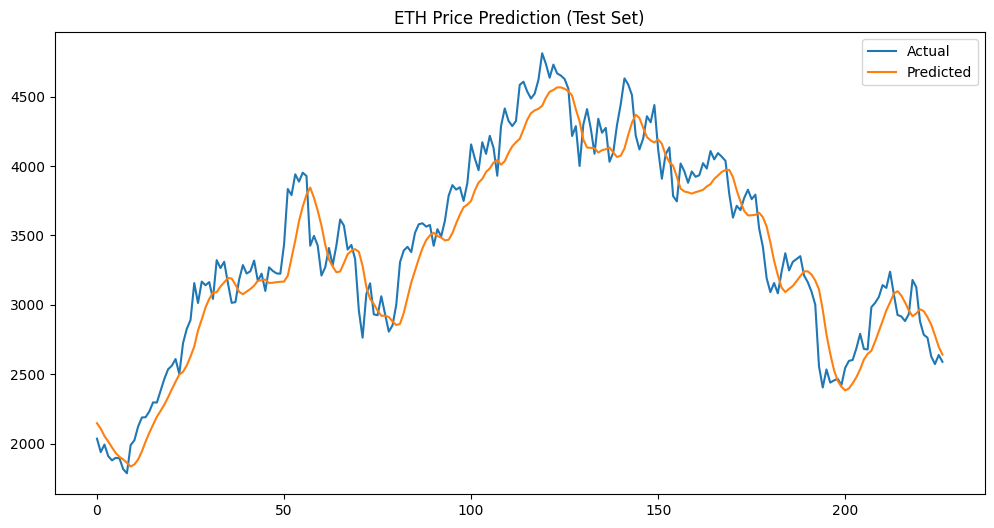

In [53]:
# Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test MSE:", test_loss, "Test MAE:", test_mae)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform (back to actual prices)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.legend()
plt.title("ETH Price Prediction (Test Set)")
plt.show()
